# Imports


In [1]:
# imports -------------------------------------------------------------
import string

import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import sklearn.model_selection as model_selection
from sklearn.metrics import confusion_matrix


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer

from sklearn.feature_extraction.text import (CountVectorizer, HashingVectorizer, TfidfVectorizer)
from imblearn.over_sampling import SMOTE

# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, TruncatedSVD


from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pathlib import Path


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
from tqdm.auto import tqdm

## Loading Data

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-summary/news_summary_more.csv
/kaggle/input/news-summary/news_summary.csv


In [3]:
df = pd.read_csv("../input/news-summary/news_summary.csv", encoding = "latin-1")
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [4]:
df.nunique()

author         45
date          240
headlines    4514
read_more    4461
text         4514
ctext        4341
dtype: int64

In [5]:
more_df = pd.read_csv('../input/news-summary/news_summary_more.csv')
more_df.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


# Preprocessing

In [6]:
# create a preprocessing class
class Preprocessor:
    def __init__(self, df) -> None:
        self.df = df

    
    # convert all charecters to lower case
    def convertToLower(self):
        self.df["headlines"] = self.df["headlines"].apply(lambda x: x.lower())
        self.df["text"] = self.df["text"].apply(lambda x: x.lower())
        return self.df

    
    # remove stop words
    def removeStopWords(self):
        stop = stopwords.words("english")
        self.df["question_text"] = self.df["question_text"].apply(
            lambda x: " ".join([word for word in x.split() if word not in stop])
        )
        return self.df

    
    # remove punctuation
    def removePunctuation(self):
        self.df["question_text"] = self.df["question_text"].str.replace("[^\w\s]", "")
        return self.df

    
    # remove numbers
    def removeNumbers(self):
        self.df["question_text"] = self.df["question_text"].str.replace("[0-9]", "")
        return self.df

    
    # remove whitespaces
    def removeWhitespaces(self):
        self.df["headlines"] = self.df["headlines"].apply(
            lambda x: " ".join(x.split())
        )
        self.df["text"] = self.df["text"].apply(
            lambda x: " ".join(x.split())
        )
        return self.df
    
    
    def cleanPunctuations(self):
        # row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower()
        self.df["headlines"] = self.df["headlines"].str.replace("[<>()|&©ø\[\]\'\",;?~*!]", "")
        self.df["text"] = self.df["text"].str.replace("[<>()|&©ø\[\]\'\",;?~*!]", "")
        return self.df
        
        
    # remove urls
    def removeURLs(self):
        self.df["question_text"] = self.df["question_text"].str.replace(
            "https?://\S+|www\.\S+", ""
        )
        return self.df

    
    # snowball stemmer algorithm
    def snowballstemmer(self):
        stemmer = SnowballStemmer()

        def stem_words(text):
            return " ".join([stemmer.stem(word) for word in text.split()])

        self.df["question_text"] = self.df["question_text"].apply(
            lambda x: stem_words(x)
        )
        return self.df

    
    # port stemmer algorithm
    def porterstemmer(self):
        stemmer = PorterStemmer()

        def stem_words(text):
            return " ".join([stemmer.stem(word) for word in text.split()])

        self.df["text"] = self.df["text"].apply(
            lambda x: stem_words(x)
        )
        
        self.df["headlines"] = self.df["headlines"].apply(
            lambda x: stem_words(x)
        )
        return self.df

    
    # lemmatizing
    def lemmatize(self):
        from nltk.stem import WordNetLemmatizer

        lemmatizer = WordNetLemmatizer()

        def lemmatize_words(text):
            return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

        self.df["question_text"] = self.df["question_text"].apply(
            lambda x: lemmatize_words(x)
        )
        return self.df

    
    # remove id and index columns
    def removeUnwantedCols(self, col):
        print(self.df.shape)
        self.df = self.df.drop(col, axis=1)
        return self.df

    
    # word tokenization using nltk
    def wordTokenization(self):
        self.df["question_text"] = self.df["question_text"].apply(
            lambda x: nltk.word_tokenize(x)
        )
        return self.df
        

    def preprocess(self):
        self.df = self.convertToLower()
        #self.df = self.removeStopWords()
        #self.df = self.removePunctuation()
        #self.df = self.removeNumbers()
        #self.df = self.removeURLs()
        self.df = self.removeWhitespaces()
        self.df = self.cleanPunctuations()
        #self.df = self.snowballstemmer()
        self.df = self.porterstemmer()
        # self.df = self.lemmatize()
        #self.df = self.wordTokenization()
        return self.df


In [7]:
preproccesor = Preprocessor(more_df)
preprocessed_df = preproccesor.preprocess()
preprocessed_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: The default value of regex will change from True to False in a future version.


,headlines,text
0,upgrad learner switch to career in ml al with ...,saurav kant an alumnu of upgrad and iiit-b pg ...
1,delhi techi win free food from swiggi for one ...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma-l india 12-match ...,new zealand defeat india by 8 wicket in the fo...
3,aegon life iterm insur plan help custom save tax,with aegon life iterm insur plan custom can en...
4,have known hirani for yr what if metoo claim a...,speak about the sexual harass alleg against ra...


In [8]:
preprocessed_df.describe()

,headlines,text
count,98401,98401
unique,98268,98338
top,a solar eclips onc prove einstein right newton...,late actress sridevi had onc reveal that she w...
freq,3,2


# Exploratory Data Analysis

In [9]:
class EDADescriber:
    def __init__(self,df):
        self.df = df
        self.punc = string.punctuation
        self.stopwords = nltk.corpus.stopwords.words('english')
        
    def count_stopwords(self,text):
        word_tokens = nltk.word_tokenize(text) #splitta i pezzi
        stopwords_x = [w for w in word_tokens if w in self.stopwords]
        return len(stopwords_x)
    
    def createSummaryDataframe(self):
        dataset = pd.DataFrame()
        dataset['headlines_sent_count'] = self.df['headlines'].apply(lambda x : len(nltk.sent_tokenize(x)))
        dataset['text_sent_count'] = self.df['text'].apply(lambda x : len(nltk.sent_tokenize(x)))
        dataset['headlines_word_count'] = self.df['headlines'].apply(lambda x : len(x.split()))
        dataset['text_word_count'] = self.df['text'].apply(lambda x : len(x.split()))
        dataset['headlines_char_count'] = self.df['headlines'].apply(lambda x : len(x.replace(" ","")))
        dataset['text_char_count'] = self.df['text'].apply(lambda x : len(x.replace(" ","")))
        dataset['headlines_word_density'] = dataset['headlines_word_count'] / (dataset['headlines_char_count'] + 1)
        dataset['text_word_density'] = dataset['text_word_count'] / (dataset['text_char_count'] + 1)
        dataset['headlines_sent_density'] = dataset['headlines_sent_count'] / (dataset['headlines_word_count'] + 1)
        dataset['text_sent_density'] = dataset['text_sent_count'] / (dataset['text_word_count'] + 1)
        dataset['headlines_punc_count'] = self.df['headlines'].apply(lambda x : len([a for a in x if a in self.punc]))
        dataset['text_punc_count'] = self.df['text'].apply(lambda x : len([a for a in x if a in self.punc]))
        dataset['text_stopw_count'] =  self.df['text'].apply(lambda x : self.count_stopwords(x))
        dataset['headlines_stopw_count'] =  self.df['headlines'].apply(lambda x : self.count_stopwords(x))
        dataset['headlines_stopw_density'] = dataset['headlines_stopw_count'] / (dataset['headlines_word_count'] + 1)
        dataset['text_stopw_density'] = dataset['text_stopw_count'] / (dataset['text_word_count'] + 1)
        return dataset
    
    
    def plot_histograms(self, plot_vars, xlim, figsize):
        import random
        data = self.createSummaryDataframe()
        fig, axes = plt.subplots(plot_vars.shape[0], plot_vars.shape[1], figsize=figsize, sharey=False, dpi=100)
        for i in range(plot_vars.shape[1]):
            sns.distplot(data[plot_vars[0,i]] , color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1),), 
                         ax=axes[i], bins= 50, norm_hist = True)
            axes[i].set_xlim(left=0, right=xlim[i])
        fig.tight_layout()

In [10]:
edaDesc = EDADescriber(df)
edadesc_summary = edaDesc.createSummaryDataframe()
edadesc_summary[['text_sent_count', 'text_word_count', 'text_char_count', 'text_stopw_count', 'text_punc_count']].describe()

,text_sent_count,text_word_count,text_char_count,text_stopw_count,text_punc_count
count,4514.000000,4514.000000,4514.000000,4514.000000,4514.000000
mean,2.899867,58.287328,297.399646,21.123837,9.969428
std,0.648635,2.320266,23.113498,3.520375,4.197057
min,1.000000,44.000000,227.000000,7.000000,2.000000
25%,3.000000,57.000000,282.000000,19.000000,7.000000
50%,3.000000,59.000000,298.000000,21.000000,9.000000
75%,3.000000,60.000000,314.000000,23.000000,12.000000
max,7.000000,62.000000,346.000000,33.000000,38.000000


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

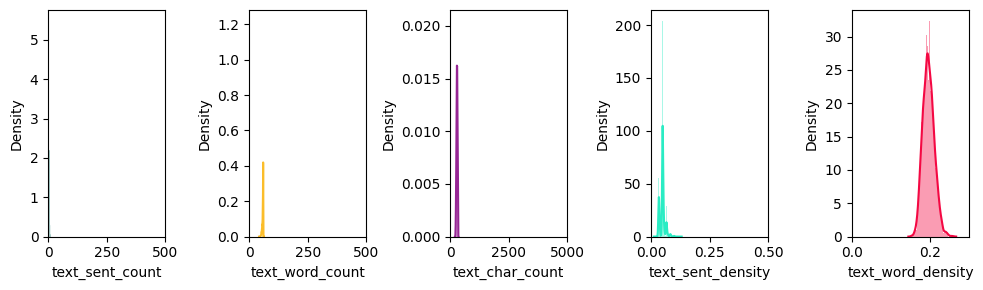

In [11]:
#Set the columns to plot
plot_vars=np.array([['text_sent_count', 'text_word_count', 'text_char_count','text_sent_density','text_word_density']])
# Plot the histograms 
edaDesc.plot_histograms(plot_vars, [500, 500, 5000, 0.5, 0.3], figsize=(10,3))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

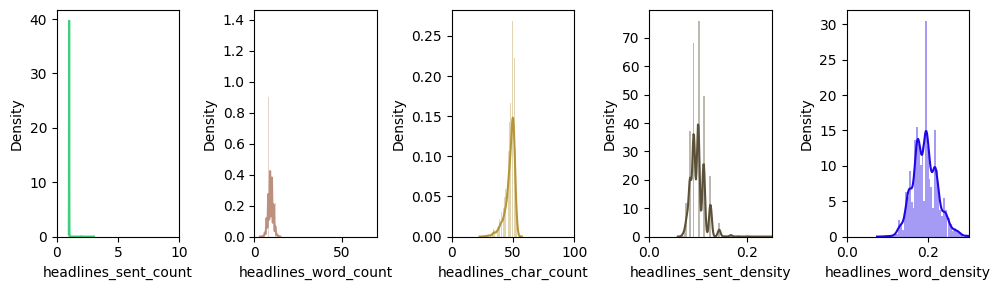

In [12]:
plot_vars=np.array([['headlines_sent_count', 'headlines_word_count', 'headlines_char_count','headlines_sent_density','headlines_word_density']])
edaDesc.plot_histograms(plot_vars, [10, 70, 100, 0.25, 0.3], figsize=(10,3))

In [13]:
df = pd.concat([df, more_df], axis=0).reset_index(drop=True)

df = df[["text", "ctext"]]
df.columns = ["summary", "text"]
df = df.dropna()
df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [14]:
train_df, test_df = model_selection.train_test_split(df, test_size =0.1)
train_df.shape, test_df.shape

((3956, 2), (440, 2))

### Word clouds & Most Frequent Terms

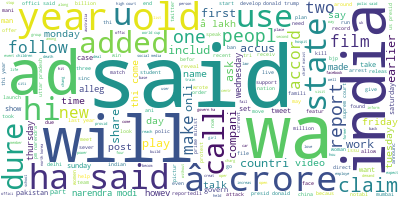

In [15]:
from wordcloud import WordCloud
long_string = ','.join(list(preprocessed_df["text"]))
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

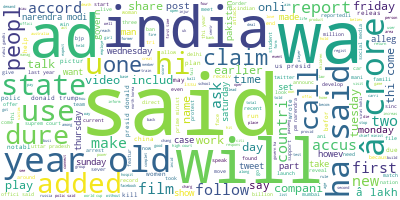

In [16]:
headline_string = ','.join(list(preprocessed_df["headlines"]))
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

### Tokenizing using T5-transformer tokenizer

In [17]:
EPOCHS = 2
BATCH_SIZE = 8

In [18]:
class SummarizerDataset(Dataset):
    def __init__(self, data: pd.DataFrame, tokenizer: T5Tokenizer, text_max_token_len: int = 512, summary_max_token_len: int = 128):
        self.data = data
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
    
    # len and getitem are mandatory methods to be overriden and cannot be removed
    def __len__(self):
        return len(self.data)      

    def __getitem__(self, index: int):
        row = self.data.iloc[index]
        text = row['text']
        summary = row['summary']
        
        # return tensors in form of pytorch tensors
        text_encoding = tokenizer(text, max_length=self.text_max_token_len, padding='max_length',
                                  truncation=True, return_attention_mask=True, add_special_tokens=True, return_tensors='pt')

        summary_encoding = tokenizer(summary, max_length=self.summary_max_token_len, padding='max_length',
                                     truncation=True, return_attention_mask=True, add_special_tokens=True, return_tensors='pt')                                             

        # All labels set to -100 are ignored (masked) -- from T5 documentation
        labels = summary_encoding['input_ids']
        labels[labels == 0] = -100 

        return dict(text=text, summary=summary, text_input_ids=text_encoding['input_ids'].flatten(),
                    text_attention_mask=text_encoding['attention_mask'].flatten(), labels=labels.flatten(),
                    labels_attention_mask=summary_encoding['attention_mask'].flatten())

In [19]:
class SummarizerDataModule(pl.LightningDataModule):
    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame, tokenizer: T5Tokenizer, batch_size: int = 8, text_max_token_len: int = 512, summary_max_token_len: int = 128):
        super().__init__()

        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    def setup(self, stage=None):
        self.train_dataset = SummarizerDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        self.test_dataset = SummarizerDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
    
    # train_dataloader , test_dataloader, val_dataloader methods are overridden, cannot be removed
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

In [20]:
class SummarizerModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
    
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

In [21]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

In [22]:
dataModule = SummarizerDataModule(train_df, test_df, tokenizer)

In [23]:
model = SummarizerModel()

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [24]:
model.model.config

T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 300,
      "num_beams": 4,
      "prefix": "translate English to German: "
    },
    "translatio

In [25]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

In [26]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


checkpointCallBack = ModelCheckpoint(
    dirpath='checkpoints',          
    filename='best-checkpoint',  
    save_top_k=1,
    verbose=True,
    monitor='val_loss',    # monitor validation loss and find the 'min' validation loss criteria
    mode='min'           
)

In [27]:
logger = TensorBoardLogger("lightning_logs", name='news-summary')

trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpointCallBack,
    max_epochs=EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f0ad79c0450>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f0ad79c0450>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Tr

In [28]:
!rm -rf lightning_logs
!rm -rf checkpoints

In [29]:
trainer.fit(model, dataModule)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [30]:
trained_model = SummarizerModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)
trained_model.freeze()

### Saving Model to Pickle

In [31]:
import pickle

# Save the Modle to file in the current working directory

Pkl_Filename1 = "Pickle_Model.pkl"  

with open(Pkl_Filename1, 'wb') as file:  
    pickle.dump(trained_model, file)

In [32]:
# Load the Model back from file
with open(Pkl_Filename1, 'rb') as file:  
    Pickled_model = pickle.load(file)

### Summary generation

In [33]:
def TextSummarizer(text):
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    generatedIDs = Pickled_model.model.generate(
        input_ids=text_encoding['input_ids'],
        attention_mask=text_encoding['attention_mask'],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    predictions = [
            tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for gen_id in generatedIDs
    ]
    return "".join(predictions)

In [34]:
for i in range(5):
    row = test_df.iloc[i]
    text = row['text']
    target = row['summary']
    predicted = TextSummarizer(text)
    
    print("text: ", text)
    print("predicted summary: ", predicted)
    print("target summary: ", target)
    print("--------------------------")

text:  The Vijay Hazare trophy quarter-final between Vidarbha and Jharkhand was all about one man. Rarely has a domestic match at this venue grabbed such attendance, but with Former India skipper Mahendra Singh Dhoni at the centre, all the commotion was expected. With Vidarbha managing just 159, the crowd at the Air Force Sports Complex in Palam was waiting for their hero to come out to bat. Every time a batsman got out, the crowd started chanting 'Dhoni Dhoni' but the Jharkhand skipper wouldn't oblige. There were other batsmen who needed the batting practice much more than the senior pro. Many were sitting close to the boundary ropes while many were trying to catch a glimpse of action from the boundary wall adjacent to the main road. 
predicted summary:  Former India captain Mahendra Singh Dhoni was the star of the Vijay Hazare Trophy quarter-final between Vidarbha and Jharkhand at the Air Force Sports Complex in Palam. The crowd started chanting 'Dhoni Dhoni' every time a batsman got

### Rouge Score

In [35]:
!pip install rouge

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [36]:
from rouge import Rouge
ROUGE = Rouge()

In [37]:
for i in range(5):
    row = test_df.iloc[i]
    text = row['text']
    target = row['summary']
    predicted = TextSummarizer(text)
    
    print("Rouge score: ",ROUGE.get_scores(predicted, target))

Rouge score:  [{'rouge-1': {'r': 0.32, 'p': 0.3404255319148936, 'f': 0.32989690222127754}, 'rouge-2': {'r': 0.06896551724137931, 'p': 0.07547169811320754, 'f': 0.0720720670822177}, 'rouge-l': {'r': 0.26, 'p': 0.2765957446808511, 'f': 0.26804123211818476}}]
Rouge score:  [{'rouge-1': {'r': 0.40476190476190477, 'p': 0.288135593220339, 'f': 0.3366336585079895}, 'rouge-2': {'r': 0.16363636363636364, 'p': 0.14516129032258066, 'f': 0.15384614886405157}, 'rouge-l': {'r': 0.38095238095238093, 'p': 0.2711864406779661, 'f': 0.31683167830996967}}]
Rouge score:  [{'rouge-1': {'r': 0.5283018867924528, 'p': 0.5283018867924528, 'f': 0.5283018817924529}, 'rouge-2': {'r': 0.2833333333333333, 'p': 0.24285714285714285, 'f': 0.26153845656804736}, 'rouge-l': {'r': 0.4339622641509434, 'p': 0.4339622641509434, 'f': 0.4339622591509435}}]
Rouge score:  [{'rouge-1': {'r': 0.4807692307692308, 'p': 0.625, 'f': 0.5434782559546314}, 'rouge-2': {'r': 0.22033898305084745, 'p': 0.28888888888888886, 'f': 0.249999995090

In [38]:
model_summary = TextSummarizer("""

John Towner Williams was born on February 8, 1932, in Flushing, Queens, New York City, to Esther (née Towner) and Johnny Williams, a jazz drummer and percussionist who played with the Raymond Scott Quintet. He is the eldest of four children and has three younger siblings: Jerry, Joan, and Donald.
Williams said of his lineage: "My father was a Maine man—we were very close. My mother was from Boston. My father's parents ran a department store in Bangor, Maine, and my mother's father was a cabinetmaker."


Williams has composed for many critically acclaimed and popular movies, including the Star Wars saga, Jaws, Close Encounters of the Third Kind, Superman, E.T. the Extra-Terrestrial, the first two Home Alone films, the Indiana Jones films, the first two Jurassic Park films, Schindler's List, and the first three Harry Potter films. 
Williams has also composed numerous classical concertos and other works for orchestral ensembles and solo instruments. He served as the Boston Pops' principal conductor from 1980 to 1993 and is its laureate conductor. He has been associated with director Steven Spielberg since 1974, composing music for all but five of his feature films, and George Lucas, with whom he has worked on both of his main franchises.
Other works by Williams include theme music for the 1984 Summer Olympic Games, NBC Sunday Night Football, "The Mission" theme used by NBC News and Seven News in Australia, the television series Lost in Space and Land of the Giants, and the incidental music for the first season of Gilligan's Island. Williams announced his intention to retire from film score composing after the release of the fifth Indiana Jones film in 2023, to focus more on composing independent orchestral and symphonic pieces.
In 2005, the American Film Institute selected Williams's score to 1977's Star Wars as the greatest film score of all time. The Library of Congress also entered the Star Wars soundtrack into the National Recording Registry for being "culturally, historically, or aesthetically significant". Williams was inducted into the Hollywood Bowl's Hall of Fame in 2000, and received a Kennedy Center Honor in 2004. His AFI Life Achievement Award in 2016 was the first to be awarded outside of the acting and directing fields.
He has composed the score for nine of the top 25 highest-grossing films at the U.S. box office (adjusted for inflation). His work has influenced other composers of film, popular, and contemporary classical music; Norwegian composer Marcus Paus argues that Williams's "satisfying way of embodying dissonance and avant-garde techniques within a larger tonal framework" makes him "one of the great composers of any century".
""")

In [39]:
model_summary

'John Towner Williams was born on February 8, 1932, in Flushing, Queens, New York City, to Esther (née Towner) and Johnny Williams, a jazz drummer and percussionist who played with the Raymond Scott Quintet. He is the eldest of four children and has three younger siblings: Jerry, Joan, and Donald. He retired from film score composing after the release of the fifth Indiana Jones film in 2023.'